<div style="text-align:center">
    <h1>
        Continuous state spaces
    </h1>
</div>

<br><br>

<div style="text-align:center">
    In this notebook we will learn how to adapt tabular methods to continuous state spaces. We will do it with two methods: 
    state aggregation and tile coding.
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 7 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [ ]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs import Maze
from utils import plot_policy, plot_tabular_cost_to_go, test_agent, plot_stats, seed_everything

## Implement state aggregation

<br><br>

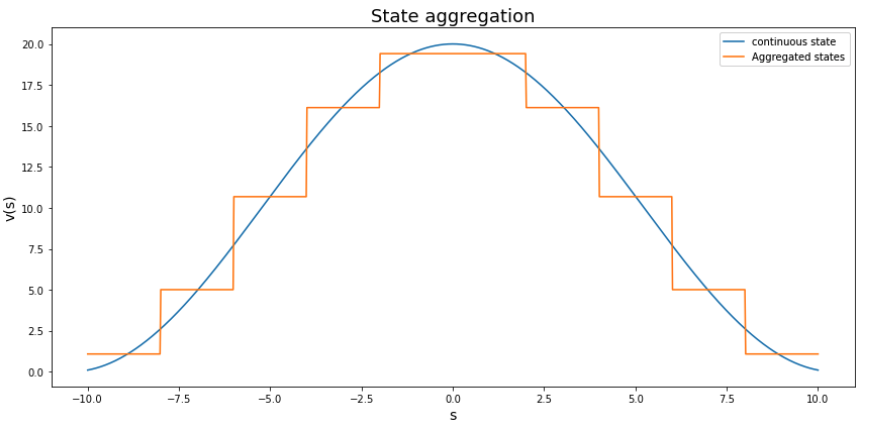

### Create the environment

### Create the state aggregation wrapper

### Compare the original environment to the one with aggregated states

In [ ]:
print(f"Modified observation space: {saenv.observation_space}, \n\
Sample state: {saenv.observation_space.sample()}")

In [ ]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.observation_space.sample()}")

### Create the $Q(s,a)$ value table

In [ ]:
action_values = np.zeros((20,20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av = action_values[state]
        return np.random.choice(np.flatnonzero(av == av.max()))

### Test the SARSA algorithm on the modified environment

In [ ]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = saenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = saenv.step(action)
            next_action = policy(next_state, epsilon)
            
            qsa = action_values[state][action]
            next_qsa = action_values[next_state][next_action]
            action_values[state][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [ ]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

In [ ]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

In [ ]:
plot_policy(action_values, env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(saenv, policy, 2)

<br><br><br><br>

## Implement Tile Coding

<br><br>

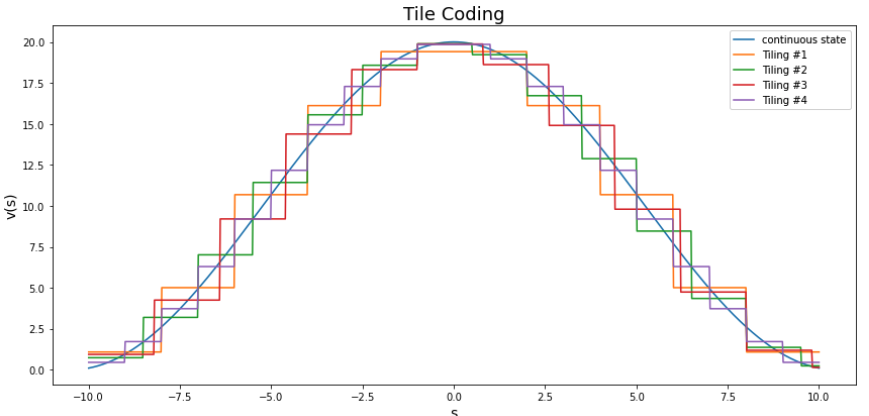

### Create the environment

### Create the Tile Coding wrapper

### Compare the original environment to the one with aggregated states

In [ ]:
print(f"Modified observation space: {tcenv.observation_space}, \n\
Sample state: {tcenv.reset()}")

In [ ]:
print(f"Original observation space: {env.observation_space}, \n\
Sample state: {env.reset()}")

### Create the $Q(s,a)$ value table

In [ ]:
action_values = np.zeros((4, 20, 20, 3))

### Create the $\epsilon$-greedy policy: $\pi(s)$

In [ ]:
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        av_list = []
        for i, idx in enumerate(state):
            av = action_values[i][idx]
            av_list.append(av)
            
        av = np.mean(av_list, axis=0)
        return np.random.choice(np.flatnonzero(av==av.max()))

### Test the SARSA algorithm on the modified environment

In [ ]:
def sarsa(action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}
    for episode in tqdm(range(1, episodes + 1)):
        state = tcenv.reset()
        action = policy(state, epsilon)
        done = False
        ep_return = 0
        while not done:
            next_state, reward, done, _ = tcenv.step(action)
            next_action = policy(next_state, epsilon)
            
            for i, (idx, next_idx) in enumerate(zip(state, next_state)):
                qsa = action_values[i][idx][action]
                next_qsa = action_values[i][next_idx][next_action]
                action_values[i][idx][action] = qsa + alpha * (reward + gamma * next_qsa - qsa)
            
            state = next_state
            action = next_action
            ep_return += reward
        stats['Returns'].append(ep_return)
    return stats

In [ ]:
stats = sarsa(action_values, policy, 20000, alpha=0.1, epsilon=0.)

In [ ]:
plot_stats(stats)

### Plot the learned policy: $\pi(s)$

In [ ]:
plot_policy(action_values.mean(axis=0), env.render(mode='rgb_array'), \
            action_meanings={0: 'B', 1: 'N', 2: 'F'})

### Plot the cost to go: $ - \max_a \hat q(s,a|\theta)$

In [ ]:
plot_tabular_cost_to_go(action_values.mean(axis=0), \
                        xlabel="Car Position", ylabel="Velocity")

### Test the resulting policy

In [ ]:
test_agent(tcenv, policy, 2)

## Resources

[[1] Reinforcement Learning: An Introduction. Section 9.5.4: Tile Coding](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)